# Demo 2: macroeconomic model in Julia. Composite sampling strategy

<table style="font-size: 110%">
    <tr style="background-color: white;">
    <td width="50%" style="vertical-align: top; text-align: left">
        We will use black-it to calibrate CATS (Complex Adaptive Trivial System) a well-known macroeconomic model that our team reimplemented in Julia.<br><br>
        The model has <strong>28 input parameters</strong> and outputs a <strong>16 components time series</strong>.<br><br>
        The high level structure of the model is illustrated on the right: <span style="background-color: #D3E7C6; font-weight: bold;">Agent classes</span> are represented in green ovals, interaction types are specified in rectangles: <span style="background-color: #FFE699; font-weight: bold;">markets</span> are yellow, <span style="background-color: #F8CBAD; font-weight: bold;">bank deposits</span> are peach.<br><br>
        The directions of the arrows indicate the flow of the specific good e.g., consumption goods are acquired by households from C-firms, while labour is acquired by firms from households.<br><br>
        </td>
    <td style="vertical-align: top; text-align: left"><div style="text-align: center">CATS high level architecture:</div><img src="data/agenc-architecture.png" alt="AgenC architechture" style="width: 500px;"/></td>
    </tr>
</table>

<div style="font-size: 112%">A fully-fledged calibration of a complex model can <strong>normally take days or weeks</strong>; in order to be able to perform a meaningful calibration during our demo, we will fix 25 parameters to known good values (input calibration), and operate on a restricted model with just <strong>3 input parameters</strong> and <strong>5 output variables</strong>.</div>

$$
\begin{aligned}
& \text {Free parameters of the restricted CATS model }\\
&\begin{array}{lll}
\hline \text { Param. } & \text { Description } & \text { Range } \\
\hline \hline
\nu & \text {Investment probability} & 0-1.0 \\
\delta^k & \text {Inventories depreciation rate} & 0-0.5 \\
\mu & \text {Bank’s gross mark-up} & 1-1.5 \\
\hline
\end{array}
\end{aligned}
$$

## Target data: US economy from 1947 to 2019

Source: FRED.

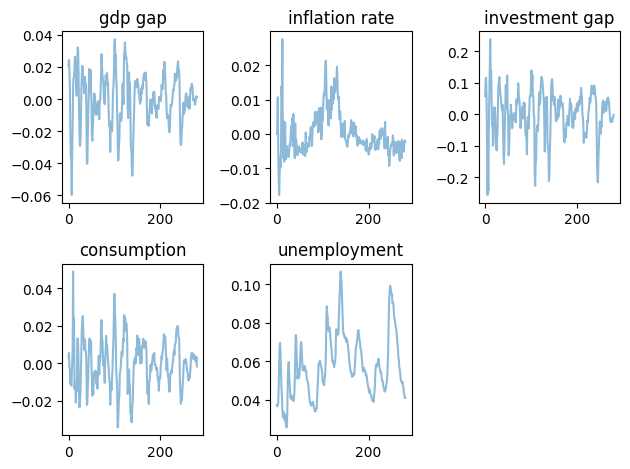

In [1]:
import cats_util

real_data = cats_util.load_fred_data()
cats_util.plot_cats_output(real_data)

## The CATS model

Bring the CATS model into scope, restricting it to just 3 input parameters for didactic purposes.

In order to verify that the Julia - black-it integration is working, let's briefly run the syntethic model with a set of arbitrary parameters, and let's have a look at the first component of the series (the GDP).

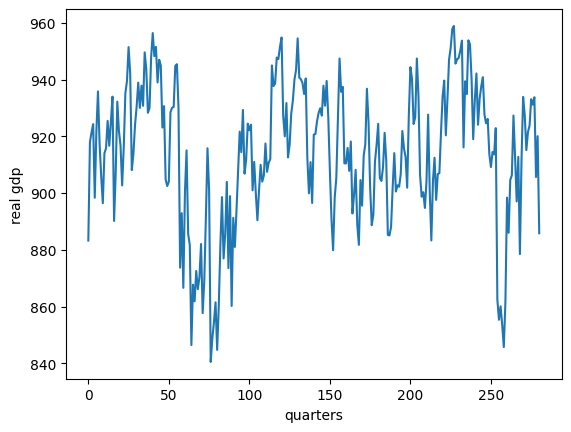

In [2]:
cats_model = cats_util.build_cats_model("/home/black-it-experiments/disk/black-it-demo/AgenC")

def restricted_cats_model(theta, N, seed):
    return cats_model.run(
        params=cats_util.found_params | {
            "Iprob": theta[0],                   # investment probability
            "inventory_depreciation": theta[1],  # Inventories depreciation rate
            "mu": theta[2],                      # Bank’s gross mark-up
        },
        nb_samples=N, 
        seed=seed,
    )

cats_util.cleanup_output_dir()
output=restricted_cats_model([0.25, 0.45,1.2], 281, 0)  # arbitrary parameters
cats_util.plot_gdp(output)

## Start configuring the calibrator

First of all, the black-it classes have to be brought in scope.

In [3]:
from black_it.calibrator import Calibrator
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.halton import HaltonSampler
from black_it.utils.time_series import log_and_hp_filter, diff_log_demean_filter

We will use a **method of moments** loss function with [Hodrick–Prescott filtering](https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter) in order to isolate the cyclical component of the time series.

This filter, togheter with a number of other advanced tools for data trasformation and intelligent search, is **already integrated in black-it**.

In [4]:
coordinate_filters = [
    log_and_hp_filter, 
    diff_log_demean_filter, 
    log_and_hp_filter, 
    log_and_hp_filter, 
    None,
]
loss = MethodOfMomentsLoss(
    coordinate_filters=coordinate_filters,
    covariance_mat="identity",
    standardise_moments=True,
)

Finalize the configuration of the calibrator. The number of possible parameters is more than **40 millions**.

In [5]:
ensemble_size = 3
cal = Calibrator(
    samplers=[],
    real_data=real_data,
    sim_length=800,
    model=restricted_cats_model,
    parameters_bounds=[[0.3, 0.5, 1.0],[0.5, 1.0, 1.4]],
    parameters_precision=[0.001, 0.001, 0.001],
    ensemble_size=ensemble_size, 
    loss_function=loss,
    saving_folder=cats_util.saving_folder,
    random_state=0,
    n_jobs=32,
)


***
Number of free params:       3.
Explorable param space size: 40381101.
***

Selecting 32 processes for the parallel evaluation of the model


/home/black-it-experiments/disk/black-it-demo/black-it/black_it/calibrator.py:99: RuntimeWarning: The length of real time series is different from the simulation length, got 281 and 800. This may or may not be a problem depending on the loss function used.
  warnings.warn(


## Run the calibration

We will start with a single pass of a **low discrepancy sampler** ([Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence)) to bootstrap the search, i.e. explore an initial set of parameters from which the ML surrogates and the genetic algorithm will start off.

In [6]:
cal.set_samplers([HaltonSampler(batch_size=8)])
params, losses = cal.calibrate(1)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler
----> sim exec elapsed time: 9.4s
---->   min loss new params: 11.42
---->   avg loss new params: 14.25
----> avg loss exist params: 14.25
---->         curr min loss: 11.421196835605015
====>    total elapsed time: 9.4s
Checkpoint saved in 0.0s


Now we can **activate more adaptive samplers**: we will use a combination of a RandomForestSampler and a genetic algorithm.

We will run 4 more calibration epochs; each epoch will take approximately 20 seconds.

In [7]:
cal.set_samplers([
    RandomForestSampler(batch_size=8),
    BestBatchSampler(batch_size=8),
])
params, losses = cal.calibrate(4)


BATCH NUMBER:   2
PARAMS SAMPLED: 8

METHOD: RandomForestSampler
----> sim exec elapsed time: 8.6s
---->   min loss new params: 11.92
---->   avg loss new params: 13.79
----> avg loss exist params: 14.02
---->         curr min loss: 11.421196835605015
====>    total elapsed time: 9.4s

METHOD: BestBatchSampler
----> sim exec elapsed time: 7.3s
---->   min loss new params: 11.44
---->   avg loss new params: 12.91
----> avg loss exist params: 13.65
---->         curr min loss: 11.421196835605015
====>    total elapsed time: 7.3s
Checkpoint saved in 0.0s

BATCH NUMBER:   3
PARAMS SAMPLED: 24

METHOD: RandomForestSampler
----> sim exec elapsed time: 7.4s
---->   min loss new params: 11.45
---->   avg loss new params: 13.12
----> avg loss exist params: 13.52
---->         curr min loss: 11.421196835605015
====>    total elapsed time: 8.2s

METHOD: BestBatchSampler
----> sim exec elapsed time: 7.4s
---->   min loss new params: 11.69
---->   avg loss new params: 13.19
----> avg loss exist pa

Retrieve the best loss we found. For our case, a value of 11 or lower would be good enough.

In [8]:
best_idx = cats_util.find_best_loss_idx(cal.losses_samp)

Best loss index: 62 (out of 72 simulations)
Best loss value: 10.79


For each calibration round, Black-it internally saves all the generated time series (and many other parameters).

Let's load the best simulation and **compare its moments with the ones of the real series**:

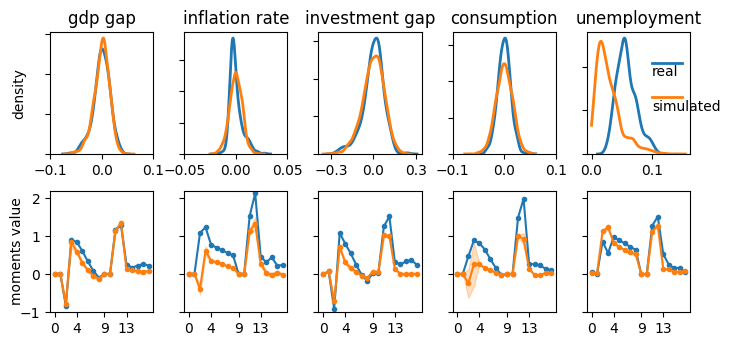

In [9]:
best_sim = cal.series_samp[best_idx]
cats_util.compare_moments(real_data, best_sim, ensemble_size, coordinate_filters)

- 0-3: mean, variance, skewness and kurtosis
- 4-8: autocorrelations of increasing time lags
- 9-12: mean, variance, skewness and kurtosis of the differentiated time series
- 13-17: autocorrelations of the differentiated time series.